In [4]:
import pandas as pd

In [5]:
main_data= pd.read_csv('./train.csv')

In [6]:
# subset_data = main_data.sample(100000)

In [7]:
# subset_data.to_csv('./subset_data.csv',index=False)

In [8]:
main_data.shape

(347841, 33)

In [9]:
case_4=main_data.copy()

In [10]:
case_4.target.value_counts()

0    316036
1     31805
Name: target, dtype: int64

In [12]:
case_4.columns

Index(['unique_id', 'metric1', 'metric2', 'metric6', 'metric3', 'metric4',
       'metric5', 'binary_var1', 'region', 'sourceMedium', 'device', 'country',
       'dayHourMinute', 'binary_var2', 'page1_top', 'page1_exits',
       'visited_page1', 'page2_top', 'page2_exits', 'visited_page2',
       'page3_top', 'page3_exits', 'visited_page3', 'page4_top', 'page4_exits',
       'visited_page4', 'page5_top', 'page5_exits', 'visited_page5',
       'page6_top', 'page6_exits', 'visited_page6', 'target'],
      dtype='object')

In [11]:
case_4.page1_exits.isna().sum()

0

In [6]:
%pprint
drop_cols=['region', 'sourceMedium','dayHourMinute']
drop_cols=drop_cols + [col for col in case_4.columns if 'exit' in col]
drop_cols

Pretty printing has been turned OFF


['region', 'sourceMedium', 'dayHourMinute', 'page1_exits', 'page2_exits', 'page3_exits', 'page4_exits', 'page5_exits', 'page6_exits']

In [7]:
case_4.drop(axis=1,columns=drop_cols,inplace=True)

In [8]:
case_4.head()

,unique_id,metric1,metric2,metric6,metric3,metric4,metric5,binary_var1,device,country,...,visited_page2,page3_top,visited_page3,page4_top,visited_page4,page5_top,visited_page5,page6_top,visited_page6,target
0,1,4,1,2,5.0,5.0,0.0,0,532c28d5412dd75bf975fb951c740a30,7d31e0da1ab99fe8b08a22118e2f402b,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0
1,2,0,1,1,0.0,0.0,100.0,0,532c28d5412dd75bf975fb951c740a30,7d31e0da1ab99fe8b08a22118e2f402b,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0
2,3,0,1,6,37.2,186.0,0.0,1,b2c79ad7dcf03ba266dc0885e1266675,7d31e0da1ab99fe8b08a22118e2f402b,...,0,0.0,0,0.0,0,0.0,0,30.0,1,0
3,4,24,1,1,0.0,0.0,100.0,0,b2c79ad7dcf03ba266dc0885e1266675,7d31e0da1ab99fe8b08a22118e2f402b,...,0,0.0,0,0.0,0,0.0,0,0.0,1,0
4,5,0,1,1,0.0,4.0,0.0,0,b2c79ad7dcf03ba266dc0885e1266675,7d31e0da1ab99fe8b08a22118e2f402b,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0


In [9]:
char_col=[]
num_col=[]
bin_col=[]
for col in list(case_4.columns):
    if case_4[col].dtype=='object':
        char_col.append(col)
    elif len(case_4[col].unique())>10:
        num_col.append(col)
    else:
        bin_col.append(col)
        

In [14]:
def out_capp(data, cols):
    for col in cols:
        data.loc[(data[col] < data[col].quantile(0.01)),col] = data[col].quantile(0.01) 
        data.loc[(data[col] > data[col].quantile(0.99)),col] = data[col].quantile(0.99)
    return data

In [15]:
case_4 = out_capp(data=case_4,cols=num_col[1:])

In [16]:
final_data = pd.get_dummies(data=case_4,columns=char_col)

In [17]:
from sklearn import preprocessing
scaled_data=pd.DataFrame(preprocessing.scale(final_data[num_col[1:]]),columns=num_col[1:])

In [18]:
final_data=pd.concat(objs=[scaled_data,final_data.drop(axis=1,inplace=False,columns=num_col)],axis=1)

In [141]:
class_0_points=int(1/5*sum(final_data.target==0))
class_0_points

63207

In [142]:
class_0=final_data.loc[final_data.target==0,:].sample(class_0_points)
class_1=final_data.loc[final_data.target==1,:]

In [143]:
balanced_data=pd.concat(objs=[class_0,class_1],axis=0)

In [144]:
balanced_data.target.value_counts()

0    63207
1    31805
Name: target, dtype: int64

In [145]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(balanced_data.drop('target',inplace=False,axis=1), balanced_data.target, test_size=0.3, random_state=101)

In [146]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(66508, 177) (28504, 177) (66508,) (28504,)


In [147]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',
                          ).fit(X_train, y_train)

C:\Users\uesr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [ ]:
import seaborn as sns 

In [168]:
from collections import Counter
y_pred=np.where(clf.predict_proba(X_test)[:,1]>0.35,1,0)

In [169]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.82      0.86     18960
           1       0.70      0.80      0.75      9544

   micro avg       0.82      0.82      0.82     28504
   macro avg       0.79      0.81      0.80     28504
weighted avg       0.83      0.82      0.82     28504



In [170]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8167625596407522

In [183]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [194]:
gb_class = AdaBoostClassifier(
DecisionTreeClassifier(class_weight='balanced',max_depth=1), n_estimators=200,
algorithm="SAMME.R", learning_rate=0.01)

In [195]:
gb_class.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.01, n_estimators=200, random_state=None)

In [196]:
accuracy_score(y_test,gb_class.predict(X_test))

0.756139489194499

In [197]:
print(classification_report(y_train,gb_class.predict(X_train)))

              precision    recall  f1-score   support

           0       0.90      0.71      0.80     44247
           1       0.60      0.84      0.70     22261

   micro avg       0.76      0.76      0.76     66508
   macro avg       0.75      0.78      0.75     66508
weighted avg       0.80      0.76      0.76     66508



In [135]:
print(classification_report(y_test,gb_class.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     31555
           1       0.72      0.62      0.66      9590

   micro avg       0.85      0.85      0.85     41145
   macro avg       0.80      0.77      0.79     41145
weighted avg       0.85      0.85      0.85     41145



In [53]:
import keras
from keras.layers import merge, Input,InputLayer
from keras.engine import InputLayer
from keras.layers import Dense, Activation
from keras.layers.core import Activation, Dense, Flatten
from keras.models import Sequential
from keras.layers import Dense

from keras.utils import np_utils
y_main_encode = np_utils.to_categorical(final_data.target, num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(final_data.drop('target',inplace=False,axis=1), y_main_encode, test_size=0.3, random_state=101)

model = Sequential()
model.add(Dense(32,input_dim=X_train.shape[1],activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

from keras.optimizers import adam
adam_=adam(lr=0.005)

model.compile(loss='mean_squared_error', optimizer=adam_,metrics=['accuracy'])

model.fit(X_train,y_train, epochs=20, batch_size=128,validation_split=0.1)

import numpy as np
y_pred=np.argmax(model.predict(X_test),axis=-1)

y_test=np.argmax(y_test,axis=-1)



from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_, y_pred)
print(cm)

model.predict(X_train)

C:\Users\uesr\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
print(classification_report(y_train,model.predict(X_train)))
print('-------------------------------------------------------')
print(classification_report(y_test,model.predict(X_test)))

In [149]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

In [ ]:
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=10))

y_score = classifier.fit(X_train, y_train).decision_function(X_test)


In [37]:
from sklearn.metrics import roc_curve, auc

In [59]:
y_score = clf.predict(X_test)
y_score

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [60]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr[0], tpr[0],_=roc_curve(y_test,y_score)
roc_auc[0]=auc(fpr[0], tpr[0])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

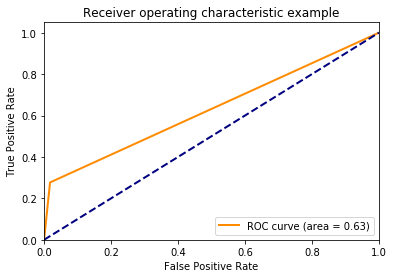

In [53]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [86]:
Counter(np.where(clf.predict_proba(X_test)[:,1]>0.3,1,0))

Counter({0: 95029, 1: 9324})

In [121]:
import numpy as np
y_thresh=np.where(clf.predict_proba(X_test)[:,1]>0.30,1,0)
y_thresh

array([0, 0, 1, ..., 0, 0, 1])

In [122]:
accuracy_score(y_test,y_thresh)

0.9102852816881163

In [123]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_thresh))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     94863
           1       0.51      0.50      0.50      9490

   micro avg       0.91      0.91      0.91    104353
   macro avg       0.73      0.72      0.73    104353
weighted avg       0.91      0.91      0.91    104353



In [40]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

ValueError: Can only tuple-index with a MultiIndex

In [38]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

ValueError: Can only tuple-index with a MultiIndex

In [129]:
pd.DataFrame(preprocessing.scale(X_train)).head()

C:\Users\uesr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,168,169,170,171,172,173,174,175,176,177
0,-1.375498,-0.270851,-0.358665,-0.528039,-0.478863,-0.473185,1.092700,-0.538462,-0.712251,-0.103916,...,-0.00608,-0.002027,-0.004964,-0.008356,-0.014331,-0.125119,-0.002866,-0.014615,-0.007307,-0.01329
1,-0.053731,-0.270851,-0.358665,-0.332962,-0.455103,-0.466232,-0.970151,-0.538462,-0.712251,-0.103916,...,-0.00608,-0.002027,-0.004964,-0.008356,-0.014331,-0.125119,-0.002866,-0.014615,-0.007307,-0.01329
2,-0.015188,-0.270851,-0.358665,-0.137884,0.471555,0.085371,-0.970151,-0.538462,-0.712251,-0.103916,...,-0.00608,-0.002027,-0.004964,-0.008356,-0.014331,-0.125119,-0.002866,-0.014615,-0.007307,-0.01329
3,0.328507,-0.270851,-0.358665,-0.528039,-0.478863,-0.473185,1.092700,-0.538462,-0.712251,-0.103916,...,-0.00608,-0.002027,-0.004964,-0.008356,-0.014331,-0.125119,-0.002866,-0.014615,-0.007307,-0.01329
4,-0.231948,-0.270851,-0.358665,0.447347,-0.391741,-0.345714,-0.970151,-0.538462,-0.712251,-0.103916,...,-0.00608,-0.002027,-0.004964,-0.008356,-0.014331,-0.125119,-0.002866,-0.014615,-0.007307,-0.01329


In [128]:
from sklearn import preprocessing
pd.DataFrame(preprocessing.scale(X_train[num_col])).head()

C:\Users\uesr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1.375498,-0.270851,-0.358665,-0.528039,-0.478863,-0.473185,1.092700,-0.103916,0.0,-0.181958,-0.104849,0.0,-0.338588
1,-0.053731,-0.270851,-0.358665,-0.332962,-0.455103,-0.466232,-0.970151,-0.103916,0.0,-0.181958,-0.104849,0.0,-0.338588
2,-0.015188,-0.270851,-0.358665,-0.137884,0.471555,0.085371,-0.970151,-0.103916,0.0,-0.181958,-0.104849,0.0,-0.338588
3,0.328507,-0.270851,-0.358665,-0.528039,-0.478863,-0.473185,1.092700,-0.103916,0.0,-0.181958,-0.104849,0.0,-0.338588
4,-0.231948,-0.270851,-0.358665,0.447347,-0.391741,-0.345714,-0.970151,-0.103916,0.0,-0.181958,-0.104849,0.0,-0.338588


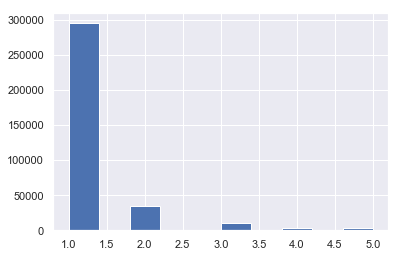

In [114]:
case_4.metric2.hist()

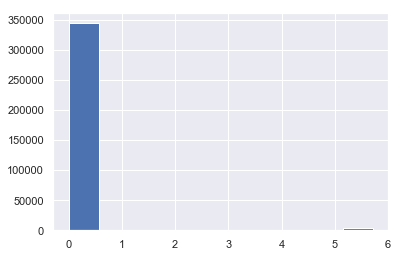

In [110]:
case_4.page1_top.hist()

In [88]:
case_4[num_col[1:]].head()

,metric1,metric2,metric6,metric3,metric4,metric5,page1_top,page2_top,page3_top,page4_top,page5_top,page6_top
0,4,1,2,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,6,37.2,186.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
3,24,1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,1,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


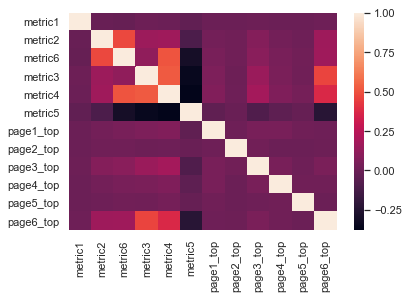

In [87]:
sns.heatmap(case_4[num_col[1:]].corr())

In [18]:
for col in case_4[char_col]:
#     print(case_4[col].value_counts())
    print('name of the variable is {} and total unique values are {}'.format(col,len(case_4[col].unique())))
    print('---------------------------------------')

name of the variable is region and total unique values are 563
---------------------------------------
name of the variable is sourceMedium and total unique values are 462
---------------------------------------
name of the variable is device and total unique values are 3
---------------------------------------
name of the variable is country and total unique values are 154
---------------------------------------


In [ ]:
case_4[bin_col]

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline


<Figure size 720x720 with 0 Axes>

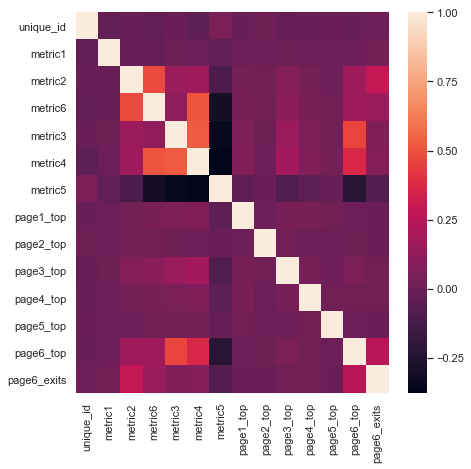

In [33]:
import seaborn as sns
fig = plt.figure(figsize = (7,7))
sns.heatmap(case_4[num_col].corr())


In [57]:
for val in bin_col:
    if 'exits' in val:
        bin_col.remove(val)
        

In [63]:
num_col

['unique_id',
 'metric1',
 'metric2',
 'metric6',
 'metric3',
 'metric4',
 'metric5',
 'page1_top',
 'page2_top',
 'page3_top',
 'page4_top',
 'page5_top',
 'page6_top',
 'page6_exits']

In [67]:
char_col

['region', 'sourceMedium', 'device', 'country']

In [66]:
for col in case_4[char_col].columns:
    print(len(case_4[col].unique()))

563
462
3
154


In [61]:
case_4[bin_col].tail()

,binary_var1,dayHourMinute,binary_var2,visited_page1,visited_page2,visited_page3,visited_page4,visited_page5,visited_page6,target
347836,0,2.017110e+11,0,0,0,0,0,0,0,0
347837,0,2.017110e+11,1,0,0,0,0,0,1,0
347838,0,2.017110e+11,0,0,0,0,0,0,0,0
347839,0,2.017110e+11,0,0,0,0,0,0,0,0
347840,0,2.017110e+11,1,0,0,1,0,0,1,0


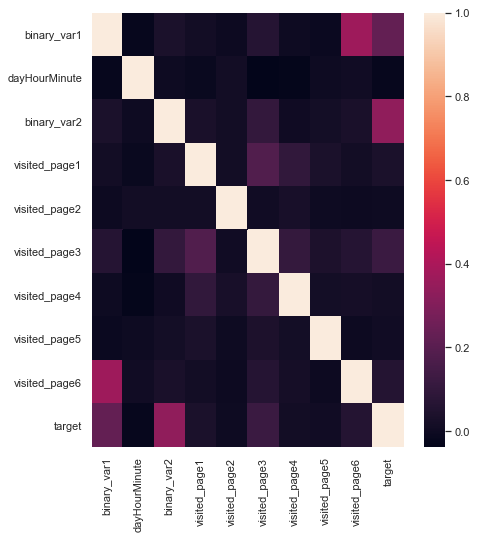

In [59]:
plt.figure(figsize=(7,8))
sns.heatmap(case_4[bin_col].corr(method='pearson'))


In [41]:
case_4[bin_col].loc[case_4.visited_page5==1,:].head()

,binary_var1,dayHourMinute,binary_var2,page1_exits,visited_page1,page2_exits,visited_page2,page3_exits,visited_page3,page4_exits,visited_page4,page5_exits,visited_page5,visited_page6,target
111,0,2.017100e+11,0,-1,0,-1,0,0,1,-1,0,0,1,1,0
390,0,2.017100e+11,1,-1,0,-1,0,-1,0,-1,0,1,1,1,0
949,0,2.017100e+11,0,-1,0,-1,0,-1,0,-1,0,0,1,0,0
1159,0,2.017100e+11,0,-1,0,-1,0,-1,0,-1,0,0,1,0,0
2349,0,2.017100e+11,0,-1,0,-1,0,-1,0,-1,0,1,1,0,0


KeyboardInterrupt: 

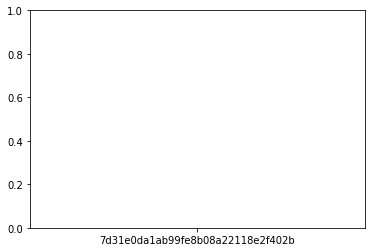

In [16]:
% matplotlib inline
case_4['country'].hist()